# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

from dstoolkit.automl import AutoMLRegressor, AutoMLRegressorCV

/home/junior/Documentos/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

## Functions

In [3]:
def generate_synthetic_regression_data(
    n_samples=2000,
    n_features=20,
    n_informative=10,
    noise=0.2,
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera dados sintéticos para problemas de regressão.
    
    Parâmetros
    ----------
    n_samples : int
        Número total de observações a serem geradas.
    n_features : int
        Número total de variáveis preditoras.
    n_informative : int
        Número de variáveis realmente informativas (as outras serão ruído).
    noise : float
        Nível de ruído adicionado à variável resposta.
    test_size : float
        Proporção da base reservada para teste.
    valid_size : float
        Proporção da base de treino reservada para validação.
    random_state : int
        Semente para reprodutibilidade.
    
    Retorna
    -------
    X_train, y_train, X_valid, y_valid, X_test, y_test : pd.DataFrame
        Bases de treino, validação e teste.
    """

    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=noise,
        random_state=random_state
    )

    # Cria DataFrames nomeados
    feature_names = [f"feature_{i}" for i in range(n_features)]
    X = pd.DataFrame(X, columns=feature_names)
    y = pd.DataFrame(y, columns=["target"])

    # Divide em treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Divide parte de treino em treino/validação
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_size, random_state=random_state
    )

    return X_train, y_train, X_valid, y_valid, X_test, y_test

## Data Base

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_regression_data(
    n_samples=6000,
    n_features=20,
    n_informative=8,
    noise=5.0
)

In [5]:
selected_columns = list(set(np.random.choice(X_train.columns.tolist(), 20)))
selected_columns

[np.str_('feature_14'),
 np.str_('feature_8'),
 np.str_('feature_5'),
 np.str_('feature_4'),
 np.str_('feature_7'),
 np.str_('feature_9'),
 np.str_('feature_18'),
 np.str_('feature_3'),
 np.str_('feature_13'),
 np.str_('feature_19'),
 np.str_('feature_15'),
 np.str_('feature_11'),
 np.str_('feature_6'),
 np.str_('feature_16')]

# Regressor

## LightGBM

In [6]:
lgbm = AutoMLRegressor(model_name='LightGBM', target='target', scoring='mean_absolute_error', tune=True, n_trials=100, random_state=42)
lgbm.train(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [7]:
lgbm.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train,0.997361,6.519024,5.445241,0.258285,8.333925,0.997361
Valid,0.989552,11.713839,8.932126,0.287020,16.655628,0.989556
Test,0.989347,12.024595,9.896867,3.958453,16.971611,0.989349


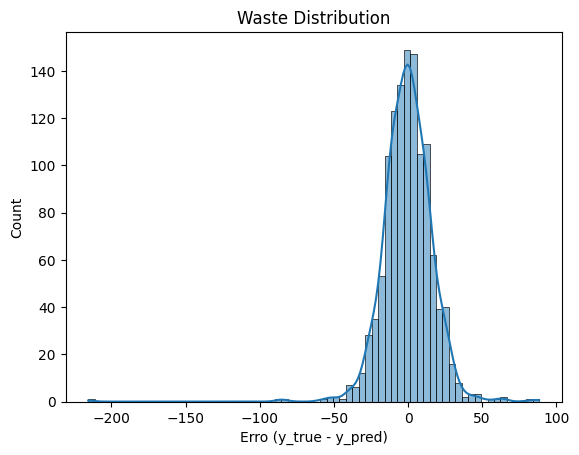

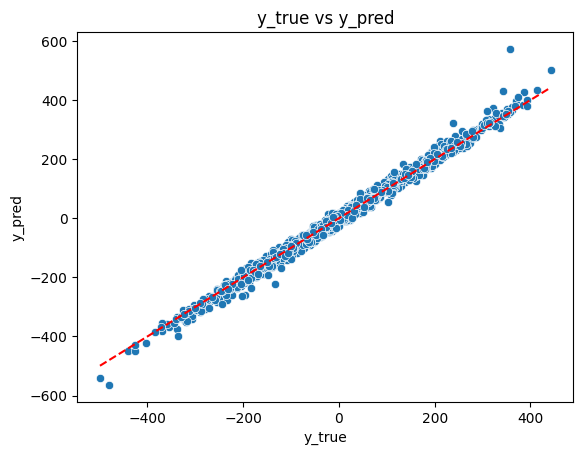

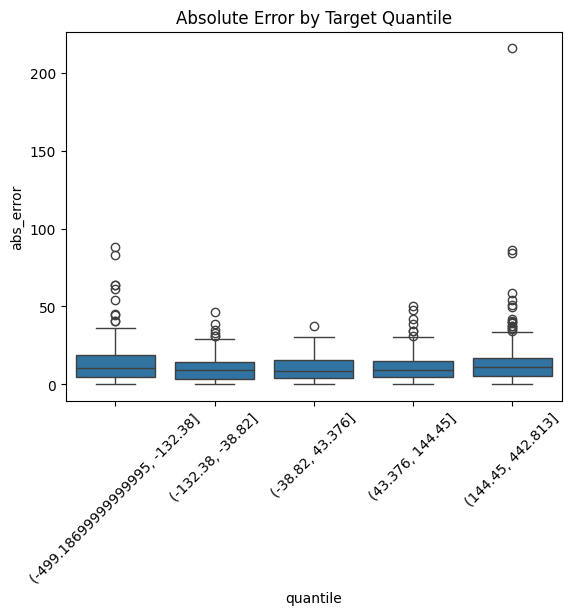

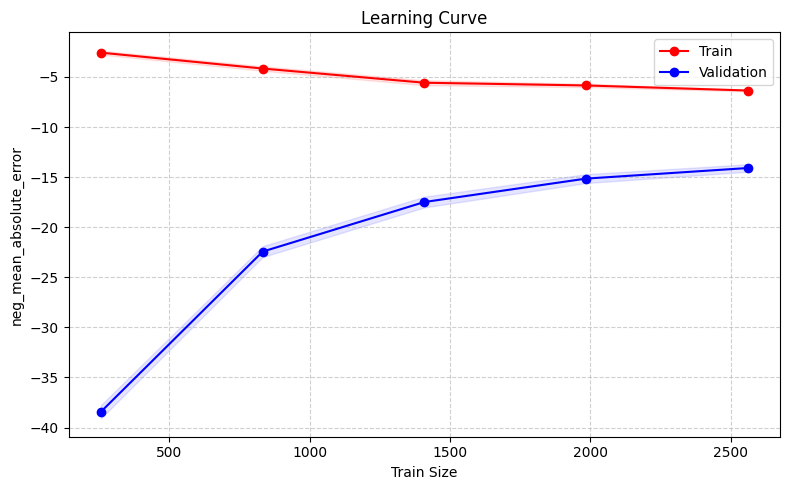

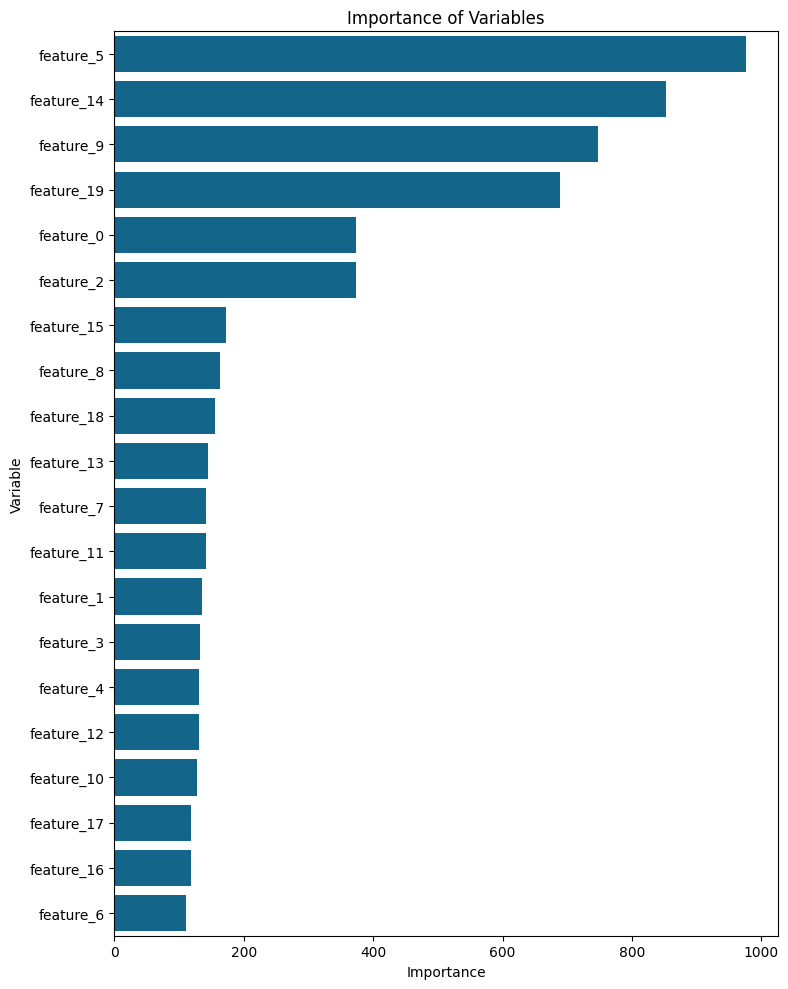

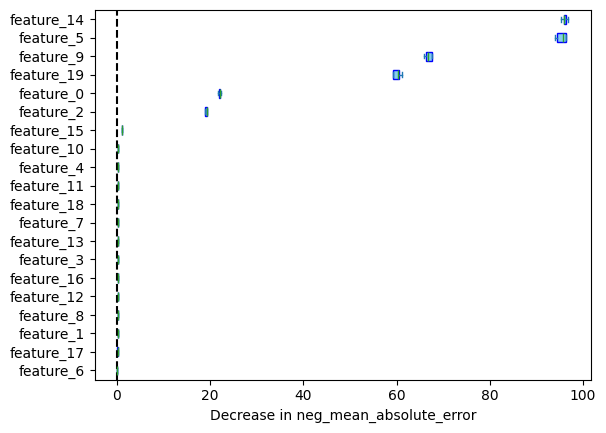

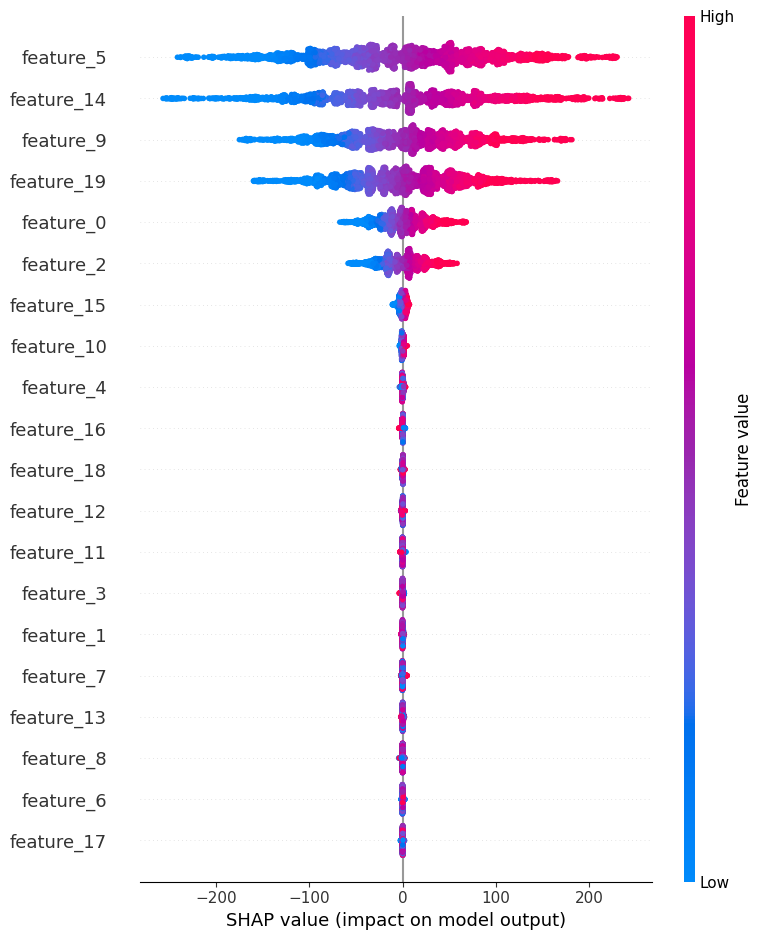

In [8]:
lgbm.analyze()

## HistGradientBoosting

In [9]:
hist = AutoMLRegressor(model_name='HistGradientBoosting', target='target', scoring='mean_absolute_percentage_error', tune=False, random_state=42)
hist.train(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [10]:
hist.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train,0.995914,8.191345,6.876867,0.292163,10.369810,0.995914
Valid,0.977143,17.946771,13.631250,0.405477,24.635306,0.977151
Test,0.978431,17.276201,13.160767,5.502413,24.149143,0.978431


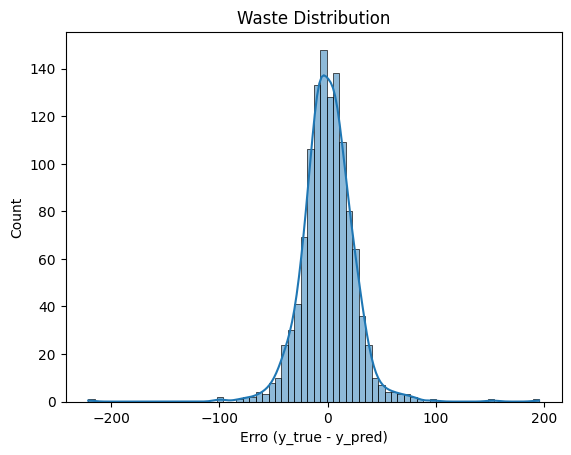

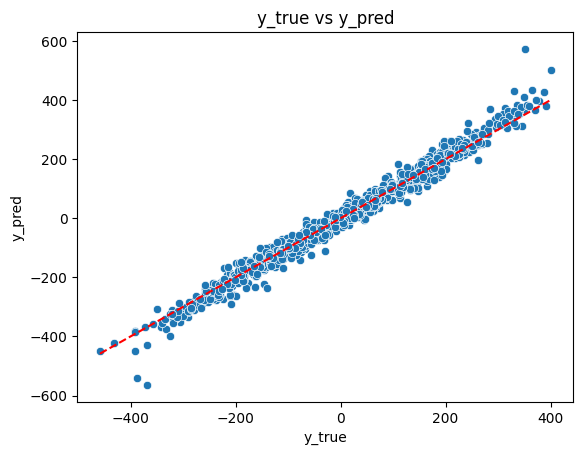

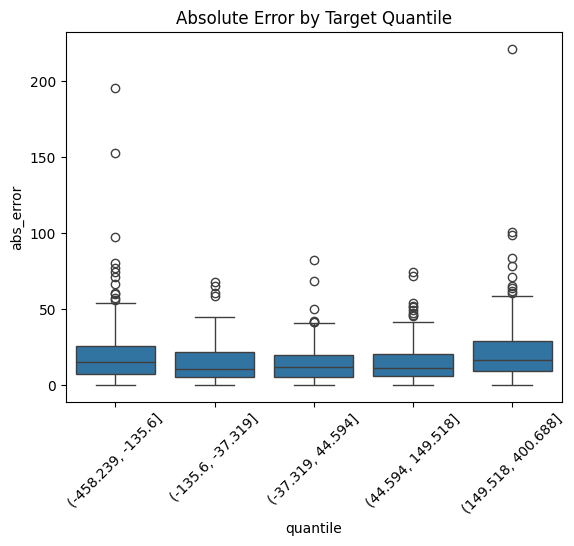

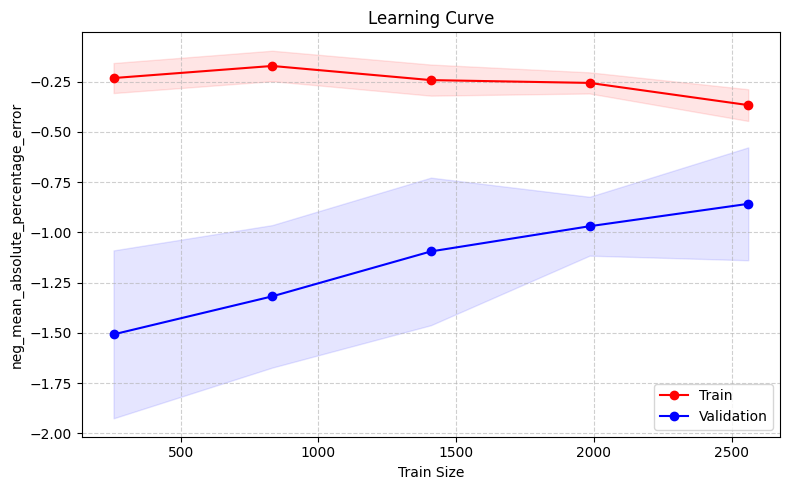

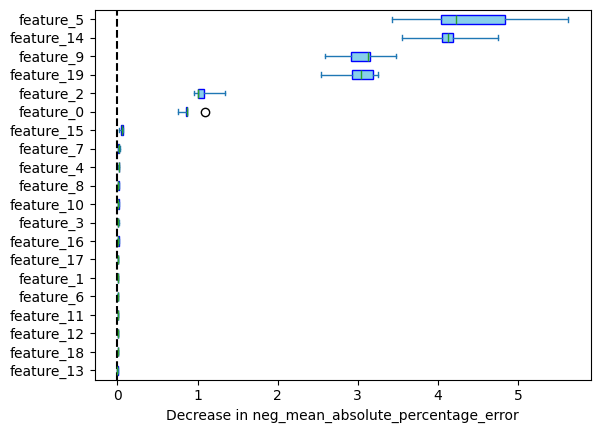

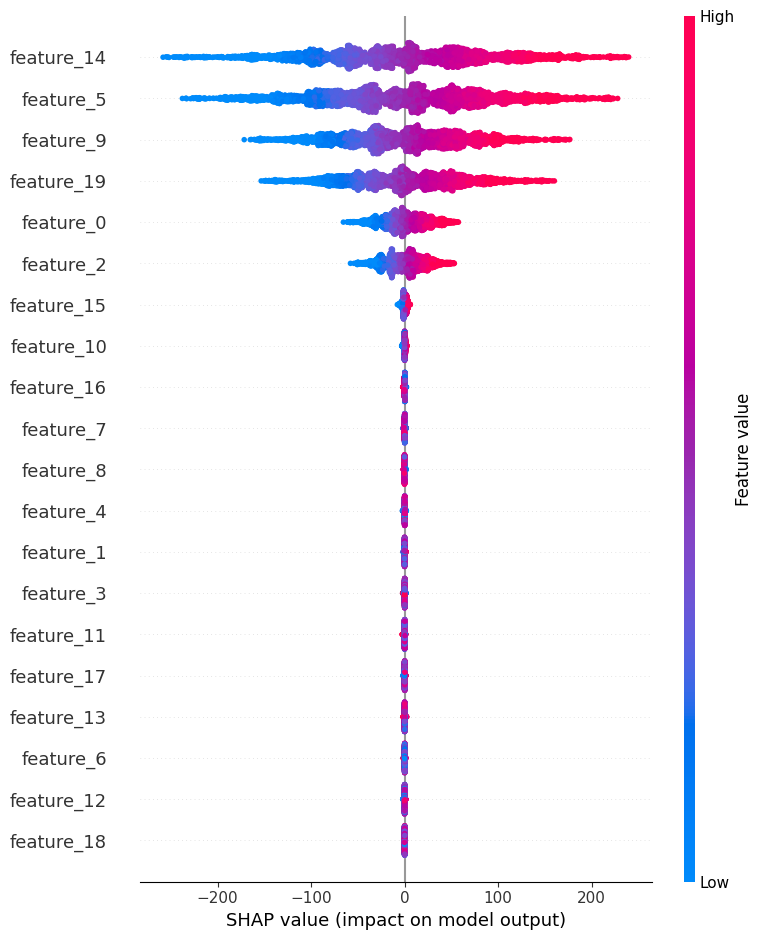

In [11]:
hist.analyze()

## CatBoost

In [12]:
cat = AutoMLRegressorCV(model_name='CatBoost', target='target', scoring='mean_absolute_error', tune=True, n_trials=50, random_state=42)
cat.train(X_train, y_train, X_test, y_test)

In [13]:
cat.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train CV,0.995544,7.961654,6.399662,0.288076,10.824622,0.99555
Test,0.995058,7.743341,5.913425,3.203340,11.559448,0.99506


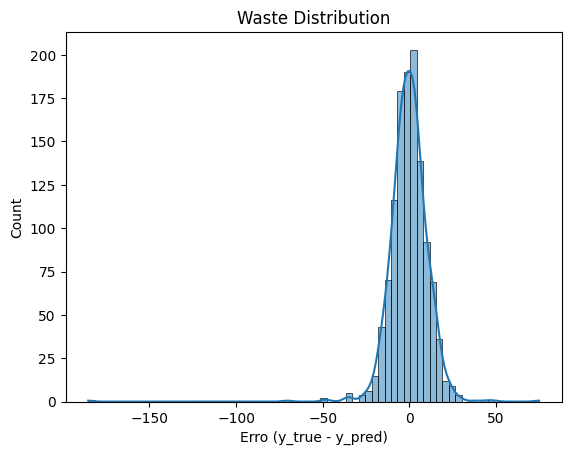

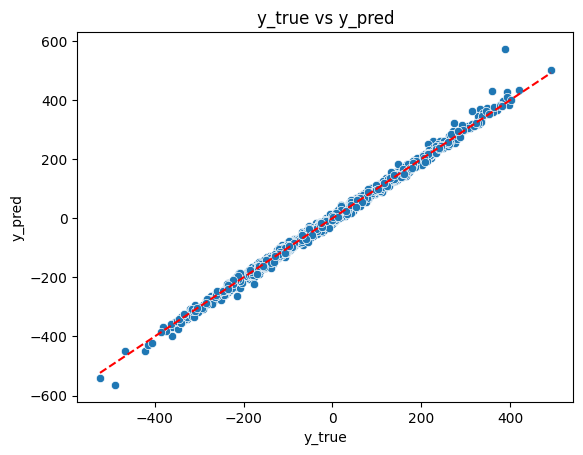

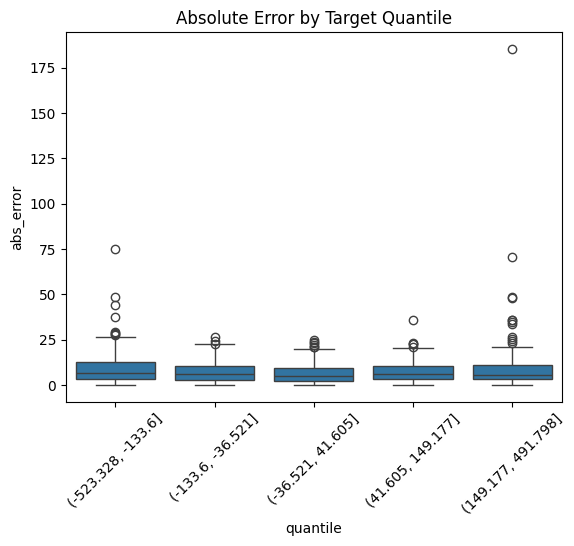

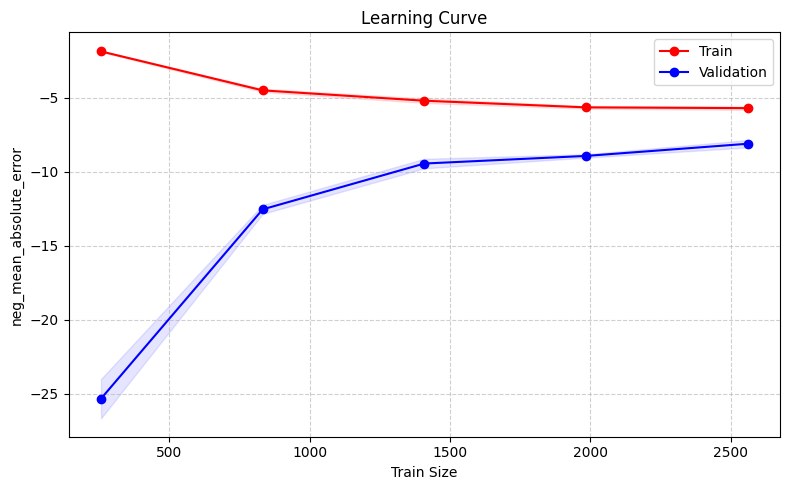

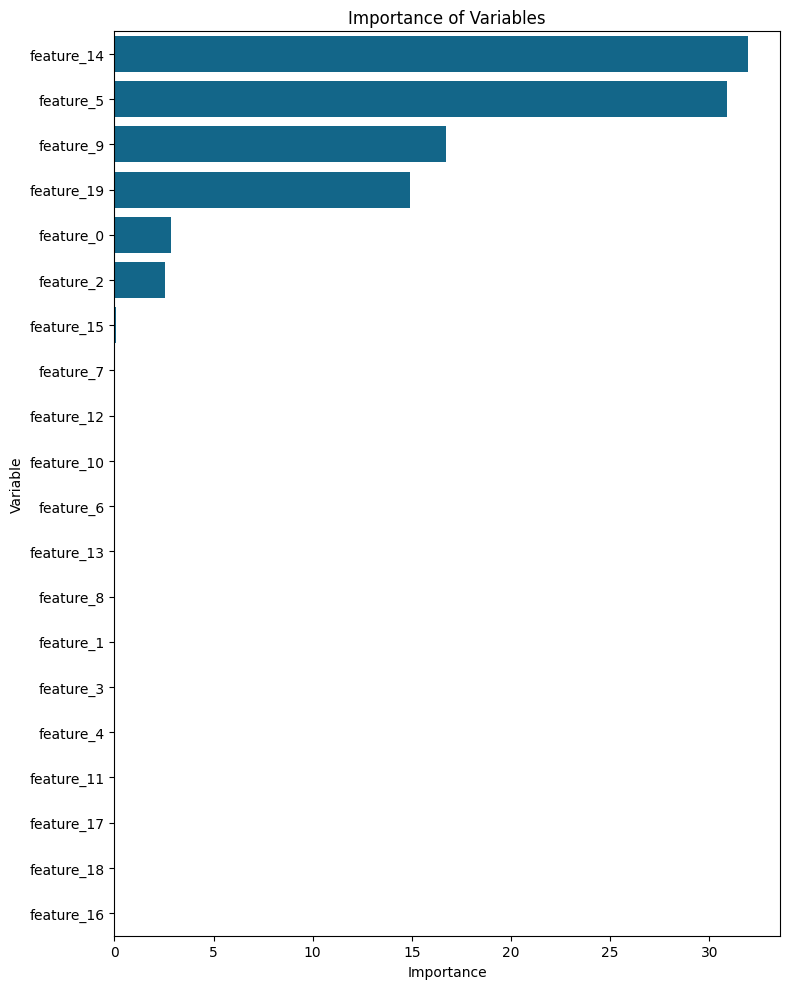

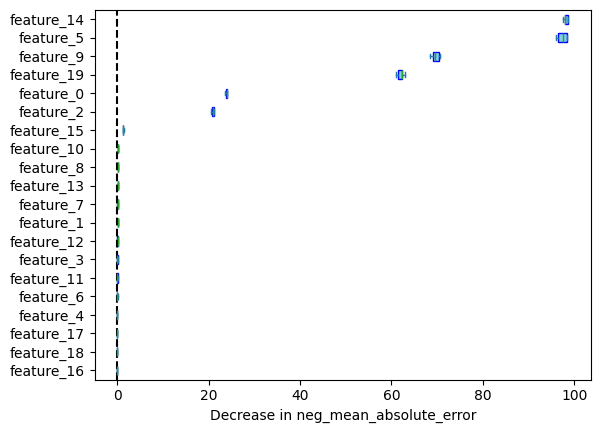

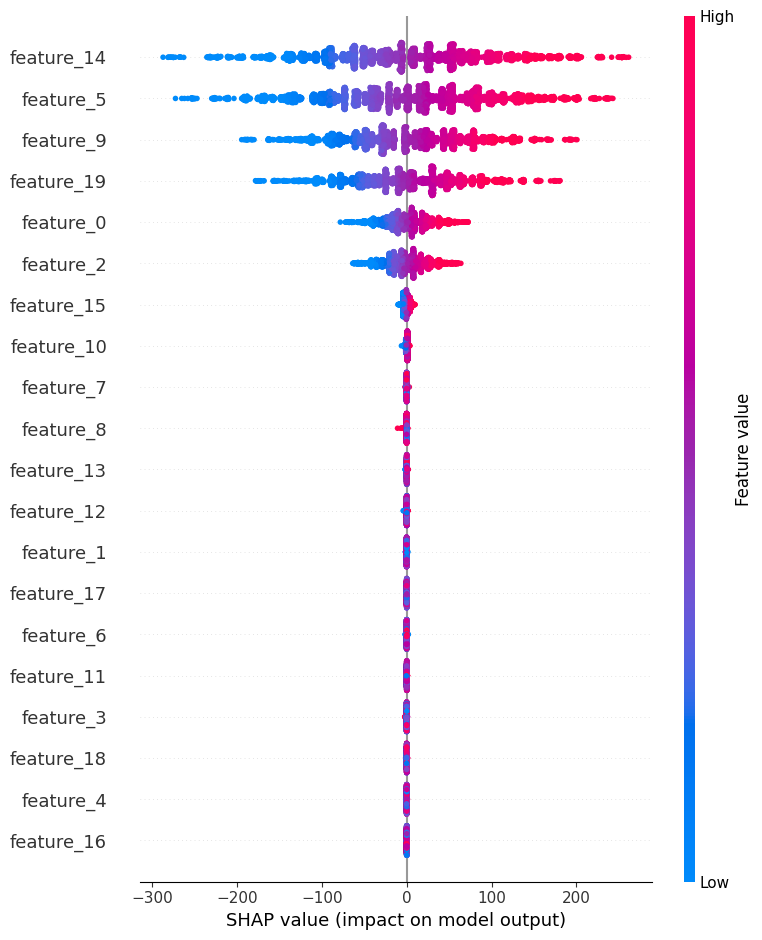

In [14]:
cat.analyze()